# Import

In [2]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from PIL import Image
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torchmetrics
from torch import optim, nn
from torch.optim.lr_scheduler import CosineAnnealingLR

from feature_extractor import MogaNet
from feature_pyramid import TransformerFCN

# Paths & Settings

In [3]:
DATA_ROOT_DIR = "data/freihand/"
SEED = 2023

CONFIG = {
    "data_dir": DATA_ROOT_DIR,
    "epochs": 1000,
    "batch_size": 16,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "optimizer": {
        "betas": (0.9, 0.999),
        'lr': 1e-3,
        'weight_decay': 0.04
    },
    'scheduler': {
        'T_max': 100, 'eta_min': 0
    }
}
CONFIG

{'data_dir': 'data/freihand/',
 'epochs': 1000,
 'batch_size': 16,
 'device': device(type='cuda'),
 'optimizer': {'betas': (0.9, 0.999), 'lr': 0.001, 'weight_decay': 0.04},
 'scheduler': {'T_max': 100, 'eta_min': 0}}

In [4]:
wandb.login(key='--')

wandb: Currently logged in as: jamoncheryev1 (navu45). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Alexey/.netrc


True

# Dataset

In [5]:
def projectPoints(xyz, K):
    """
    Projects 3D coordinates into image space.
    Function taken from https://github.com/lmb-freiburg/freihand
    """
    xyz = torch.Tensor(xyz)
    K = torch.Tensor(K)
    uv = torch.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]


RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 384
IN_FEATURES = 3
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.1966, 0.1734, 0.1836]
COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}


In [6]:
class FreiHAND(Dataset):
    """
    Class to load FreiHAND dataset. Only training part is used here.
    Augmented images are not used, only raw - first 32,560 images

    Link to dataset:
    https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html
    """

    def __init__(self, config, sample=False, set_type="train"):
        self.image_dir = Path(config['data_dir'] + 'training/rgb')
        self.image_names = np.sort(os.listdir(self.image_dir))
        self.sample = sample

        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        if set_type == "train":
            n_start = 0
            n_end = 26000
        elif set_type == "val":
            n_start = 26000
            n_end = 31000
        else:
            n_start = 31000
            n_end = len(self.anno)
            
        #n_start = 0
        #n_end = 4

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))
        image = self.image_transform(image_raw)
        image_raw = self.image_raw_transform(image_raw)
        
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / RAW_IMG_SIZE
        
        if self.sample:
            return {
                "image": image,
                "keypoints": keypoints,
                'image_raw': image_raw
            }
        else:
            return [image, keypoints]

# Lightning Data Module

In [7]:
class FreiHANDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size: int = 32,
                 num_workers: int = 4,
                 sample=False,
                 config=CONFIG):
        super().__init__()
        self.dataset_val = None
        self.dataset_train = None
        self.dataset_predict = None
        self.dataset_test = None
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.config = config
        self.sample = sample
        
    def setup(self, stage: str):
        if stage == "test":
            self.dataset_test = FreiHAND(self.config, sample=self.sample, set_type='test')
        if stage == "predict":
            self.dataset_predict = FreiHAND(self.config, set_type='test')
        if stage == "fit":
            self.dataset_train = FreiHAND(self.config, set_type='train')
            self.dataset_val = FreiHAND(self.config, set_type='val')

    def _dataloader(self, dataset):
        return DataLoader(dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)

    def train_dataloader(self):
        return self._dataloader(self.dataset_train)

    def val_dataloader(self):
        return self._dataloader(self.dataset_val)

    def test_dataloader(self):
        return self._dataloader(self.dataset_test)

    def predict_dataloader(self):
        return self._dataloader(self.dataset_predict)


In [8]:
def show_data(dataset, n_samples=12):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image_raw"].numpy()
        image = np.moveaxis(image, 0, -1)
        keypoints = sample["keypoints"].cpu().numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()

In [9]:
data_module = FreiHANDataModule(batch_size=16, sample=True, num_workers=4, config=CONFIG)
data_module.setup('test')

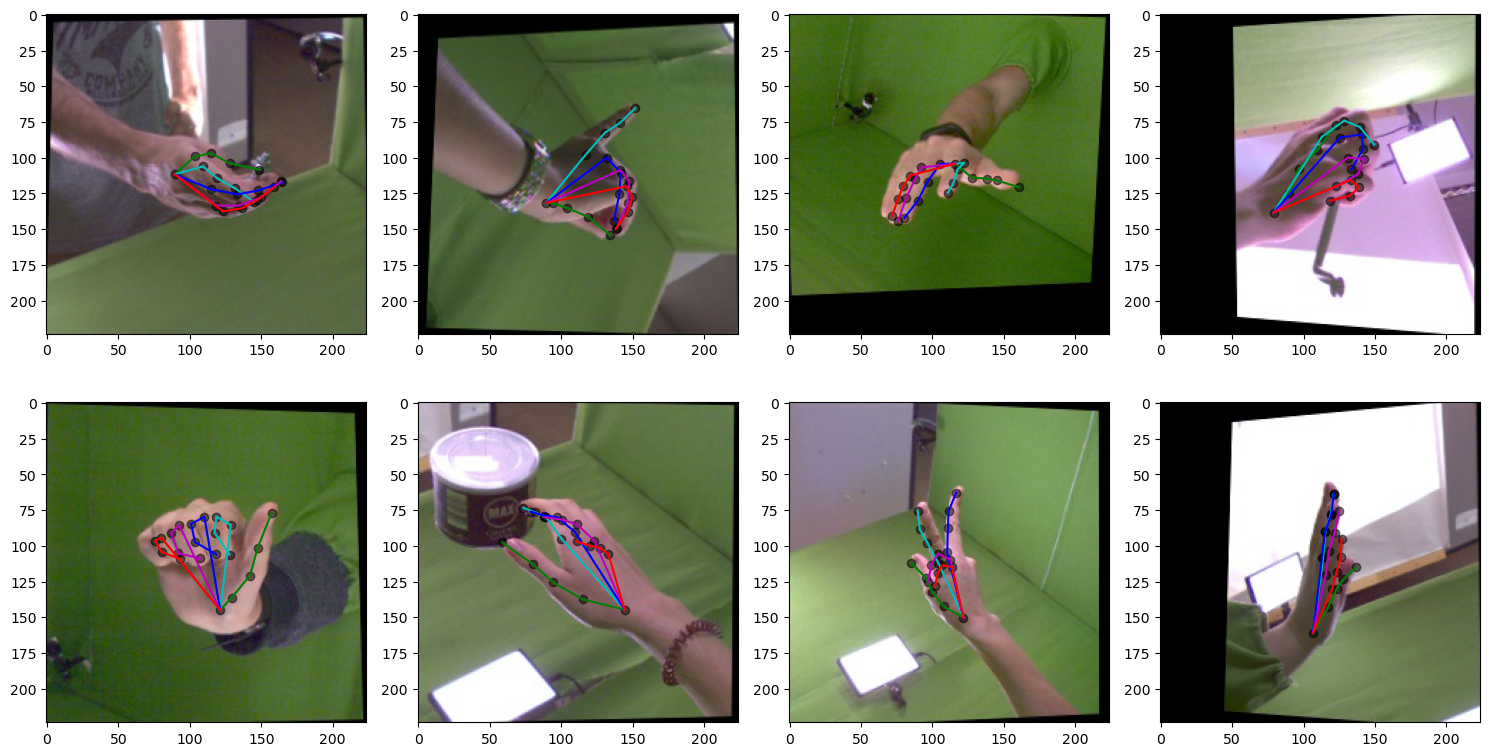

In [10]:
show_data(data_module.dataset_test, n_samples=8)

# Lightning Module

In [11]:
class MPJPELoss(nn.Module):
    @staticmethod
    def forward(pred_joints, y_joints):
        x = torch.sum(pred_joints - y_joints, dim=-1)
        distance_per_image = torch.mean(x.pow(2), dim=1)
        return torch.mean(distance_per_image)

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


class HandKeypointDetector(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.backbone = MogaNet(
            in_channels=3,
            out_indices=[1, 2, 3],
            depths=[3, 3, 10, 2],
            widths=[32, 64, 96, 192],
            stem_act_type='GELU',
            stem_norm_type='LN',
            moga_ratio=[1, 3, 4],
            moga_dilations=[1, 2, 3],
            drop_path_rate=0.1,
            drop_rate=0.1,
            ffn_scales=[8, 8, 4, 4],
            ffn_act_type='GELU',
            fd_act_type='GELU',
            moga_act_type='SiLU'
        )
        self.head = TransformerFCN(
            in_channels_layers=[[64, 96, 192], [108, 152, 144]],
            fused_channels_layers=[[216, 304, 288], [-1, 368, 480]],
            out_channels_layers=[[108, 152, 144], [108, 184, 240]],
            depths_layers=[[3, 3, 3], [2, 3, 3]],
            mlp_ratio_layers=[[4, 4, 4], [2, 2, 2]],
            transformer_norm_type='LN',
            mlp_drop_rate=0.1,
            mlp_act_type='GELU',
            attn_proj_act_type='ReLU',
            attn_norm_type='LN',
            drop_path_rate=0.1,
            avg_pool_outputs=[2, 4, 6],
            num_joints=21,
            num_classes=0,
        )
        self.init_parameters()
        self.config = config
        self.criterion = torch.nn.L1Loss()
        self.metric = MPJPELoss()

    def init_parameters(self):
        for name, m in self.named_modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.00001, 1.0 / m.weight.shape[1])
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.00001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0001)
                nn.init.constant_(m.running_mean, 0)

    def forward(self, images):
        # assert not torch.isnan(images).any(), 'Input creates nan'
        img_features = self.backbone(images)
        # assert not torch.isnan(img_features[-1]).any(), 'Backbones creates nan'
        outputs = self.head(img_features)
        # assert not torch.isnan(outputs).any(), 'Neck or Head creates nan'
        return outputs

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), **self.config['optimizer'])
        scheduler = CosineAnnealingWarmRestarts(optimizer, **self.config['scheduler'])
        return [optimizer], [scheduler]

    def _step(self, batch):
        x, y = batch
        assert not torch.isnan(y).any(), 'Input creates nan'
        outputs = self.forward(x)
        loss = self.criterion(outputs, y)
        metric = self.metric(outputs, y)
        assert not torch.isnan(loss).any(), 'Loss calculates nan'
        return loss, metric

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        loss, metric = self._step(batch)
        self.log("train_L1", loss, sync_dist=True)
        self.log("train_MPJPE", metric, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        loss, metric = self._step(batch)
        self.log("val_L1", loss, sync_dist=True)
        self.log("val_MPJPE", metric, sync_dist=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        loss, metric = self._step(batch)
        self.log("test_L1", loss, sync_dist=True)
        self.log("test_MPJPE", metric, sync_dist=True)

# Prepare for training

In [13]:
import torch
a = torch.randint(1, 5, [16, 3, 2], dtype=torch.float)
b = torch.randint(1, 5, [16, 3, 2], dtype=torch.float)
a, b

(tensor([[[1., 2.],
          [2., 2.],
          [1., 4.]],
 
         [[2., 2.],
          [2., 1.],
          [1., 3.]],
 
         [[1., 3.],
          [1., 3.],
          [4., 3.]],
 
         [[3., 3.],
          [4., 4.],
          [4., 2.]],
 
         [[4., 2.],
          [4., 4.],
          [2., 3.]],
 
         [[3., 1.],
          [1., 3.],
          [1., 2.]],
 
         [[2., 4.],
          [1., 4.],
          [2., 3.]],
 
         [[1., 2.],
          [2., 1.],
          [2., 3.]],
 
         [[2., 2.],
          [2., 2.],
          [1., 4.]],
 
         [[2., 1.],
          [4., 4.],
          [3., 1.]],
 
         [[4., 3.],
          [1., 2.],
          [1., 3.]],
 
         [[2., 3.],
          [1., 2.],
          [1., 1.]],
 
         [[2., 3.],
          [2., 2.],
          [1., 4.]],
 
         [[4., 1.],
          [4., 1.],
          [2., 4.]],
 
         [[4., 2.],
          [1., 2.],
          [2., 1.]],
 
         [[1., 2.],
          [2., 1.],
          [2., 

In [14]:
a - b

tensor([[[-2.,  0.],
         [ 1.,  1.],
         [ 0.,  1.]],

        [[-2., -2.],
         [-2., -3.],
         [-2.,  2.]],

        [[-1., -1.],
         [-1.,  1.],
         [ 1., -1.]],

        [[-1., -1.],
         [ 1.,  1.],
         [ 3., -2.]],

        [[ 1., -1.],
         [ 1.,  0.],
         [ 1.,  1.]],

        [[ 2., -2.],
         [ 0.,  2.],
         [ 0.,  1.]],

        [[-1.,  1.],
         [-2.,  0.],
         [-2.,  2.]],

        [[-3., -2.],
         [ 0., -1.],
         [-2., -1.]],

        [[ 0., -1.],
         [-1., -1.],
         [-2.,  1.]],

        [[-2., -1.],
         [ 3.,  3.],
         [ 0., -1.]],

        [[ 2., -1.],
         [-1., -2.],
         [-3.,  1.]],

        [[-2.,  2.],
         [-1.,  1.],
         [ 0., -2.]],

        [[-2.,  2.],
         [ 1., -1.],
         [-3.,  0.]],

        [[ 0., -1.],
         [ 3., -3.],
         [ 1.,  2.]],

        [[ 1.,  1.],
         [-1., -2.],
         [-2., -3.]],

        [[ 0.,  0.],
    

In [15]:
x = torch.sum(a - b, dim=-1)
x.shape, x

(torch.Size([16, 3]),
 tensor([[-2.,  2.,  1.],
         [-4., -5.,  0.],
         [-2.,  0.,  0.],
         [-2.,  2.,  1.],
         [ 0.,  1.,  2.],
         [ 0.,  2.,  1.],
         [ 0., -2.,  0.],
         [-5., -1., -3.],
         [-1., -2., -1.],
         [-3.,  6., -1.],
         [ 1., -3., -2.],
         [ 0.,  0., -2.],
         [ 0.,  0., -3.],
         [-1.,  0.,  3.],
         [ 2., -3., -5.],
         [ 0.,  0., -5.]]))

In [16]:
torch.mean(x.pow(2), dim=1)

tensor([ 3.0000, 13.6667,  1.3333,  3.0000,  1.6667,  1.6667,  1.3333, 11.6667,
         2.0000, 15.3333,  4.6667,  1.3333,  3.0000,  3.3333, 12.6667,  8.3333])

In [17]:
def load_logger_and_callbacks(
    fast_dev_run, metrics, overfit_batches, patience, project
):
    if fast_dev_run or overfit_batches > 0:
        logger, callbacks = None, None
    else:
        logger, id_ = get_logger(metrics=metrics, project=project)
        callbacks = get_callbacks(
            id_=id_,
            mode=list(metrics.values())[0],
            monitor=list(metrics.keys())[0],
            patience=patience
        )

    return logger, callbacks


def get_logger(metrics, project):
    logger = WandbLogger(project=project)
    id_ = logger.experiment.id

    for metric, summary in metrics.items():
        logger.experiment.define_metric(metric, summary=summary)

    return logger, id_


def get_callbacks(id_, mode, monitor, patience):
    callbacks = [
        EarlyStopping(monitor=monitor, mode=mode, patience=patience),
        LearningRateMonitor(),
        ModelCheckpoint(save_last=True, save_on_train_epoch_end=True),
    ]

    return callbacks

# Training

In [18]:
def train(
    accelerator: str = "gpu",
    batch_size: int = 10,
    fast_dev_run: bool = False,
    max_epochs: int = 200,
    # num_workers: int = 4,
    overfit_batches: int = 0,
    patience: int = 20,
    precision: int = '16-mixed',
    project: str = "freihand",
):
    pl.seed_everything(43)

    if fast_dev_run:
        num_workers = 0

    data_module = FreiHANDataModule(
        batch_size=batch_size,
        # num_workers=num_workers,
        config=CONFIG
    )

    module = HandKeypointDetector(CONFIG)

    logger, callbacks = load_logger_and_callbacks(
        fast_dev_run=fast_dev_run,
        metrics={"val_loss": "min", "val_acc": "max", "val_f1": "max"},
        overfit_batches=overfit_batches,
        patience=patience,
        project=project,
    )

    trainer = pl.Trainer(
        accelerator=accelerator,
        benchmark=True,
        devices="auto",
        callbacks=callbacks,
        fast_dev_run=fast_dev_run,
        logger=logger,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        max_steps=max_epochs,
        num_sanity_val_steps=0,
        overfit_batches=overfit_batches,
        precision=precision,
    )

    trainer.fit(module, datamodule=data_module)

    return module

In [19]:
wandb.finish()

In [22]:
data_module = FreiHANDataModule(
        batch_size=CONFIG['batch_size'],
        # num_workers=num_workers,
        config=CONFIG
    )
module = HandKeypointDetector(CONFIG)
trainer = pl.Trainer(
        accelerator='gpu',
        benchmark=True,
        devices="auto",
        max_epochs=1,
        num_sanity_val_steps=0,
        precision='16',
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
from torchsummary import summary

summary(module.backbone, (3, 384, 384), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 192, 192]              30
          Identity-2          [-1, 3, 192, 192]               0
            Conv2d-3         [-1, 16, 192, 192]              64
   SeparableConv2d-4         [-1, 16, 192, 192]               0
       LayerNorm2d-5         [-1, 16, 192, 192]              32
              GELU-6         [-1, 16, 192, 192]               0
            Conv2d-7           [-1, 16, 96, 96]             160
          Identity-8           [-1, 16, 96, 96]               0
            Conv2d-9           [-1, 32, 96, 96]             544
  SeparableConv2d-10           [-1, 32, 96, 96]               0
      LayerNorm2d-11           [-1, 32, 96, 96]              64
             Stem-12           [-1, 32, 96, 96]               0
      BatchNorm2d-13           [-1, 32, 96, 96]              64
           Conv2d-14           [-1, 32,

In [72]:
from torch.utils.mobile_optimizer import optimize_for_mobile

# module.eval()
example = torch.rand(1, 3, 384, 384)
traced_script_module = torch.jit.trace(module, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("model.ptl")

C:\Users\Alexey\anaconda3\envs\hands-tracking\lib\site-packages\torch\jit\_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 42 / 42 (100.0%)
Greatest absolute difference: 431.62744140625 at index (0, 13, 0) (up to 1e-05 allowed)
Greatest relative difference: 3.6639148684373914 at index (0, 14, 1) (up to 1e-05 allowed)
  _check_trace(


In [ ]:
trainer.fit(module, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | backbone  | MogaNet          | 2.8 M 
1 | head      | TransformerFCN   | 8.7 M 
2 | criterion | MeanSquaredError | 0     
-----------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.139    Total estimated model params size (MB)


In [ ]:
model = train()

Global seed set to 43


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | backbone  | MogaNet          | 2.8 M 
1 | head      | TransformerFCN   | 8.7 M 
2 | criterion | MeanSquaredError | 0     
-----------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.139    Total estimated model params si

In [ ]:
torch.save(model, 'model.pt')